In [1]:
# Cài đặt gdown
!pip install gdown

In [2]:
import os

current_dir = os.getcwd()
print(current_dir)

/kaggle/working


In [3]:
ls -a

./  ../  __notebook__.ipynb


In [4]:
import os

# In ra tên thư mục đang làm việc
current_dir = os.getcwd()
print("Thư mục đang làm việc:", current_dir)


# Đường dẫn tới file zip trên Google Drive
file_id = '1z5eW4UZS9v13iAcrQ0RhPIOaVYZAXTiX'  # Thay bằng ID của file của bạn
url = f'https://drive.google.com/uc?id={file_id}'

# Tải file zip từ Google Drive
output_zip = os.path.join(current_dir, 'traffic_sign_board.zip')
!gdown {url} -O {output_zip}

# Giải nén file zip
output_dir = os.path.join(current_dir, 'traffic_sign_board')
os.makedirs(output_dir, exist_ok=True)
!unzip -q {output_zip} -d {output_dir}

# In ra các tệp trong thư mục sau khi giải nén
print("Các tệp trong thư mục sau khi giải nén:")
!ls {output_dir}


Thư mục đang làm việc: /kaggle/working
Downloading...
From (original): https://drive.google.com/uc?id=1z5eW4UZS9v13iAcrQ0RhPIOaVYZAXTiX
From (redirected): https://drive.google.com/uc?id=1z5eW4UZS9v13iAcrQ0RhPIOaVYZAXTiX&confirm=t&uuid=de46baf6-729f-4a6e-bf3f-f11f6ed5ede2
To: /kaggle/working/traffic_sign_board.zip
100%|████████████████████████████████████████| 229M/229M [00:06<00:00, 37.0MB/s]
Các tệp trong thư mục sau khi giải nén:
content


In [5]:
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import random
import torch
import torchvision
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [6]:
import os
import cv2
import xml.etree.ElementTree as ET

def load_traffic_signboard_dataset_test(mode):
    dataset_dir = '/kaggle/working/traffic_sign_board/content/drive/MyDrive/CS231/dataset/traffic_sign_board'
    image_dir = os.path.join(dataset_dir, 'images')
    annotation_dir = os.path.join(dataset_dir, 'annotations')

    # Kiểm tra mode để quyết định tệp tin train.txt hoặc test.txt cần sử dụng
    if mode == 'train':
        txt_file = 'train.txt'
    elif mode == 'test':
        txt_file = 'test.txt'
    else:
        raise ValueError("Invalid mode. Mode must be 'train' or 'test'.")

    # Đường dẫn đến tệp tin chứa danh sách các file XML cần load
    txt_path = os.path.join(dataset_dir, txt_file)

    # Đọc danh sách các file XML từ tệp tin train.txt hoặc test.txt
    with open(txt_path, 'r') as file:
        xml_files = file.read().splitlines()

    # Khởi tạo danh sách rỗng cho dữ liệu hình ảnh, nhãn và bounding boxes
    image_list = []
    label_list = []
    bounding_boxes = []

    # Lặp qua từng file XML và load dữ liệu
    for annotation_file in xml_files:
        file_path = os.path.join(annotation_dir, annotation_file)
        tree = ET.parse(file_path)
        root = tree.getroot()
        
        image_file = root.find('filename').text
        image_path = os.path.join(image_dir, image_file)
        img = cv2.imread(image_path)
        image_label = []
        bounding_box = []
        for object in root.findall('object'):
            label = object.find('name').text
            if label == 'trafficlight':
                continue
            xmin = int(object.find('bndbox/xmin').text)
            ymin = int(object.find('bndbox/ymin').text)
            xmax = int(object.find('bndbox/xmax').text)
            ymax = int(object.find('bndbox/ymax').text)
            bounding_box.append([xmin, ymin, xmax, ymax])
            image_label.append(label)
        if label != 'trafficlight':
            image_list.append(img)
            label_list.append(image_label)
            bounding_boxes.append(bounding_box)

    return image_list, label_list, bounding_boxes

# Example usage:
train_images, train_labels, train_bboxes = load_traffic_signboard_dataset_test(mode='train')
test_images, test_labels, test_bboxes = load_traffic_signboard_dataset_test(mode='test')


In [7]:
len(train_images)

692

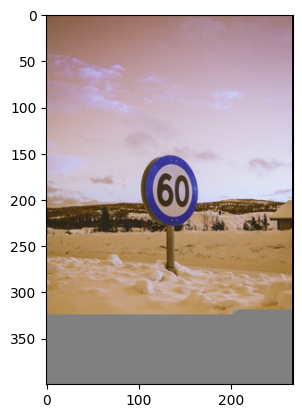

In [8]:
import matplotlib.pyplot as plt
plt.imshow(test_images[0])

In [9]:
class TrafficSignDataset(Dataset):
    def __init__(self, images, labels, bounding_boxes, transforms=None):
        self.images = images
        self.labels = labels
        self.bounding_boxes = bounding_boxes
        self.transforms = transforms
        self.label_map = {'stop': 1, 'speedlimit': 2, 'crosswalk': 3}  # Class labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        target = {}
        boxes = self.bounding_boxes[idx]
        labels = self.labels[idx]
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor([self.label_map[label] for label in labels], dtype=torch.int64)
        
        target["boxes"] = boxes
        target["labels"] = labels
        
        img = F.to_tensor(img)
        
        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))



In [10]:
# Create dataset and dataloader
train_dataset = TrafficSignDataset(train_images, train_labels, train_bboxes)
test_dataset = TrafficSignDataset(test_images, test_labels, test_bboxes)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)



In [11]:
# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 4  # stop, speedlimit, crosswalk + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 132MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [12]:

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Calculate loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backprop
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        i += 1
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {losses.item():.4f}")
    
    # Update the learning rate
    lr_scheduler.step()

    # Save the model
model_save_path = '/kaggle/working/model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Epoch [1/10], Step [10/173], Loss: 0.5338
Epoch [1/10], Step [20/173], Loss: 0.2888
Epoch [1/10], Step [30/173], Loss: 0.1588
Epoch [1/10], Step [40/173], Loss: 0.2060
Epoch [1/10], Step [50/173], Loss: 0.0836
Epoch [1/10], Step [60/173], Loss: 0.2069
Epoch [1/10], Step [70/173], Loss: 0.0936
Epoch [1/10], Step [80/173], Loss: 0.1201
Epoch [1/10], Step [90/173], Loss: 0.1558
Epoch [1/10], Step [100/173], Loss: 0.0411
Epoch [1/10], Step [110/173], Loss: 0.0951
Epoch [1/10], Step [120/173], Loss: 0.0448
Epoch [1/10], Step [130/173], Loss: 0.0523
Epoch [1/10], Step [140/173], Loss: 0.0569
Epoch [1/10], Step [150/173], Loss: 0.0881
Epoch [1/10], Step [160/173], Loss: 0.0557
Epoch [1/10], Step [170/173], Loss: 0.0759
Epoch [2/10], Step [10/173], Loss: 0.0991
Epoch [2/10], Step [20/173], Loss: 0.0791
Epoch [2/10], Step [30/173], Loss: 0.0458
Epoch [2/10], Step [40/173], Loss: 0.0758
Epoch [2/10], Step [50/173], Loss: 0.0443
Epoch [2/10], Step [60/173], Loss: 0.0724
Epoch [2/10], Step [70/173

In [13]:
from sklearn.metrics import precision_recall_fscore_support

def calculate_metrics(true_boxes, true_labels, pred_boxes, pred_labels, iou_threshold=0.5):
    """
    Calculate Average Precision (AP), Average Recall (AR) and F1 Score.
    """
    all_true_labels = []
    all_pred_labels = []

    for t_labels, p_labels in zip(true_labels, pred_labels):
        all_true_labels.extend(t_labels)
        all_pred_labels.extend(p_labels)

    precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_pred_labels, average='macro')
    return precision, recall, f1_score


In [14]:
import matplotlib.pyplot as plt

def visualize_predictions(image, true_boxes, true_labels, pred_boxes, pred_labels, label_map, save_dir, image_id):
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

#     # Draw ground truth boxes in green
#     for box, label in zip(true_boxes, true_labels):
#         xmin, ymin, xmax, ymax = box
#         plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='green', facecolor='none', linewidth=2))
#         plt.text(xmin, ymin, label_map[label], color='green', fontsize=12, bbox=dict(facecolor='green', alpha=0.5))

    # Draw predicted boxes in red
    for box, label in zip(pred_boxes, pred_labels):
        xmin, ymin, xmax, ymax = box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='green', facecolor='none', linewidth=2))
        plt.text(xmin, ymin, label_map[label], color='black', fontsize=12, bbox=dict(facecolor='green', alpha=0.5))

    plt.axis('off')
    print(f'{image_id}')
    
    
     # Save the figure
    save_path = os.path.join(save_dir, f"{image_id}.png")
    plt.savefig(save_path)
    plt.show()
    plt.close()


outputs=[{'boxes': tensor([[102.6181, 151.1540, 164.2976, 228.8642]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[107.0136,  90.2974, 174.1227, 176.6488]], device='cuda:0'), 'labels': tensor([3], device='cuda:0'), 'scores': tensor([0.9774], device='cuda:0')}, {'boxes': tensor([[304.6451, 130.1560, 327.9243, 152.9557],
        [161.9139,  28.5344, 182.1436,  49.6243]], device='cuda:0'), 'labels': tensor([3, 3], device='cuda:0'), 'scores': tensor([0.9929, 0.9900], device='cuda:0')}, {'boxes': tensor([[190.8488,  26.6714, 336.6954, 218.1960],
        [196.0073,  46.7396, 330.4580, 207.4334]], device='cuda:0'), 'labels': tensor([3, 1], device='cuda:0'), 'scores': tensor([0.9363, 0.0959], device='cuda:0')}]
0


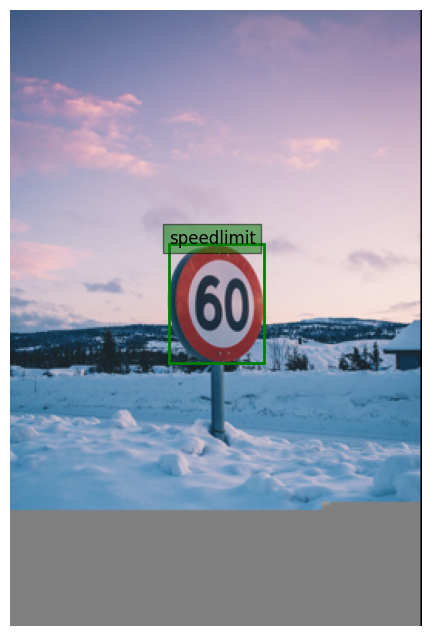

1


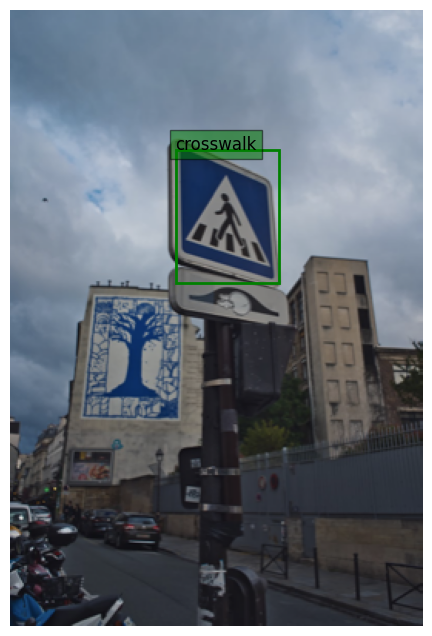

2


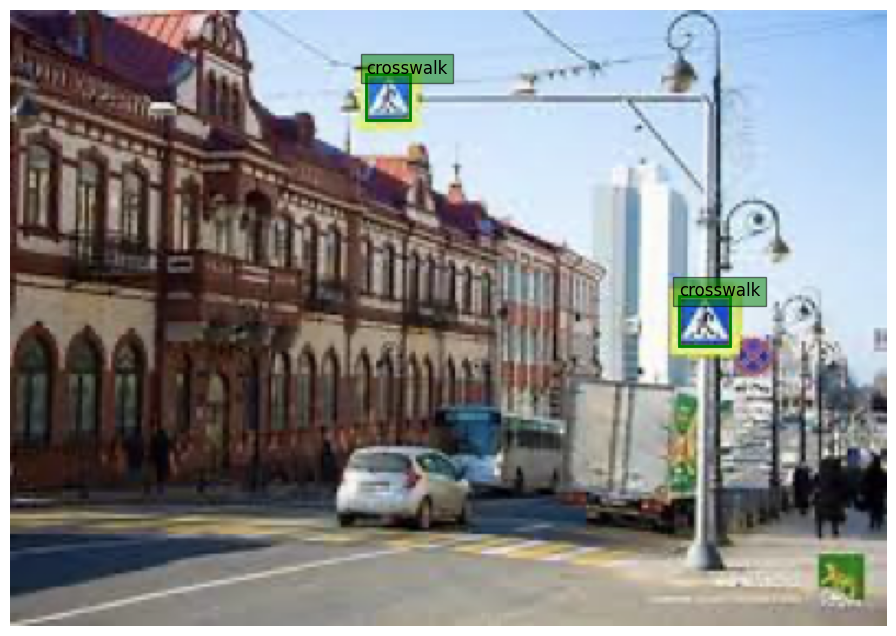

3


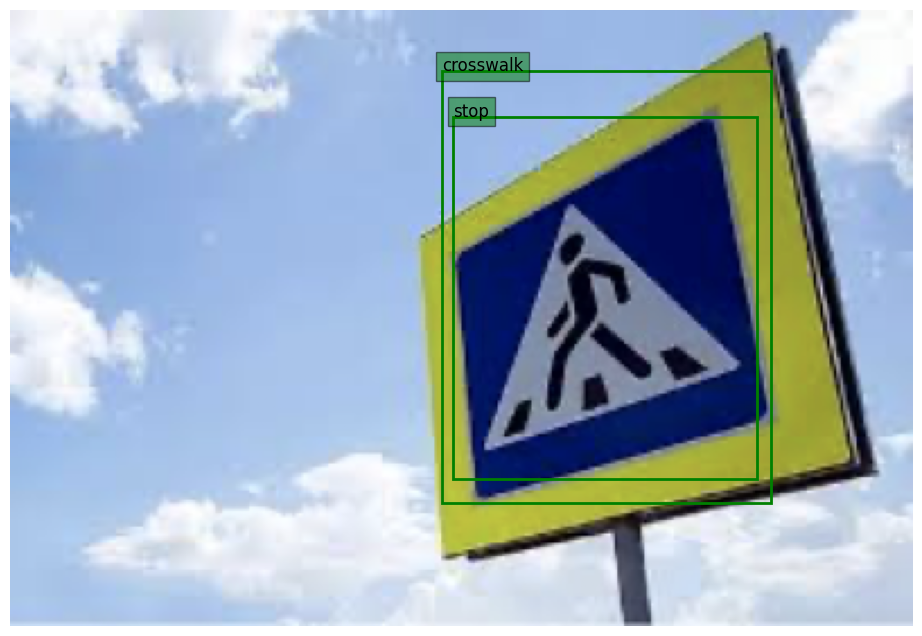

3.635714054107666


In [15]:
import time
def evaluate(model, data_loader, device, label_map, save_dir):
    start_time = time.time()
    model.eval()
    true_boxes = []
    true_labels = []
    pred_boxes = []
    pred_labels = []
    image_id = 0
    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):
            if i >= 1:
                break
            images = list(img.to(device) for img in images)
            outputs = model(images)
            print(f'{outputs=}')
            
            for i, image in enumerate(images):
                true_boxes.append(targets[i]['boxes'].cpu().numpy())
                true_labels.append(targets[i]['labels'].cpu().numpy())
                
                pred_boxes.append(outputs[i]['boxes'].cpu().numpy())
                pred_labels.append(outputs[i]['labels'].cpu().numpy())

                # Visualize
                visualize_predictions(
                    image.cpu().permute(1, 2, 0).numpy(),
                    true_boxes[-1],
                    true_labels[-1],
                    pred_boxes[-1],
                    pred_labels[-1],
                    label_map, save_dir, 
                    image_id
                )
                image_id += 1
    print(time.time() - start_time)
    return true_boxes, true_labels, pred_boxes, pred_labels

# Define label map
label_map = {1: 'stop', 2: 'speedlimit', 3: 'crosswalk'}

# Evaluate on test set
save_dir = '/kaggle/working/output'
import os
os.makedirs(save_dir, exist_ok=True)
true_boxes, true_labels, pred_boxes, pred_labels = evaluate(model, test_loader, device, label_map, save_dir)


In [16]:
print(f'{(true_boxes[2])=}')
# print(f'{len(true_labels)=}')
# print(f'{len(pred_boxes)=}')
# print(f'{len(pred_labels)=}')

(true_boxes[2])=array([[162.,  30., 181.,  50.],
       [305., 131., 329., 154.]], dtype=float32)


In [17]:
def evaluate_detection(pred_boxes, pred_labels, gt_boxes, gt_labels, iou_threshold=0.5):
    """
    Evaluate precision and recall for object detection.

    Args:
        pred_boxes (list of list): Predicted bounding boxes [x1, y1, x2, y2].
        pred_labels (list): Predicted labels.
        gt_boxes (list of list): Ground truth bounding boxes [x1, y1, x2, y2].
        gt_labels (list): Ground truth labels.
        iou_threshold (float): IoU threshold to consider a valid detection.

    Returns:
        precision (float), recall (float)
    """
    assert len(pred_boxes) == len(pred_labels)
    assert len(gt_boxes) == len(gt_labels)

    TP = 0
    FP = 0
    FN = 0

    detected_gt = [False] * len(gt_boxes)

    for pred_box, pred_label in zip(pred_boxes, pred_labels):
        match_found = False
        for i, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
            if pred_label == gt_label and iou(pred_box, gt_box) >= iou_threshold:
                if not detected_gt[i]:
                    TP += 1
                    detected_gt[i] = True
                    match_found = True
                    break
        if not match_found:
            FP += 1

    FN = detected_gt.count(False)

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0

    return precision, recall

In [18]:
def iou(box1, box2):
    """ Compute the Intersection over Union (IoU) of two bounding boxes. """
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    # Compute the coordinates of the intersection rectangle
    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)

    # Compute the area of intersection rectangle
    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x2g - x1g + 1) * (y2g - y1g + 1)

    # Compute the intersection over union by taking the intersection area
    # and dividing it by the sum of prediction + ground-truth areas - inter_area
    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

In [19]:
# true_boxes, true_labels, pred_boxes, pred_labels
sum_precision = 0
sum_recall = 0
for pred_box, pred_label, gt_box, gt_label in zip(pred_boxes, pred_labels, true_boxes, true_labels):  
    precision, recall = evaluate_detection(pred_box, pred_label, gt_box, gt_label)
    #print(f"Precision: {precision}, Recall: {recall}")
    sum_precision += precision
    sum_recall += recall
average_precision = sum_precision / len(pred_boxes)
average_recall = sum_recall / len(pred_boxes)
f1_score = 2 * average_precision * average_recall / (average_precision + average_recall)
print(f"Average Precision: {average_precision}, Average Recall: {average_recall}, F1 Score: {f1_score}") 
# epochs = 5: Average Precision: 0.780761904761905, Average Recall: 0.985, F1 Score: 0.8710692807637336
# epochs = 10: Average Precision: 0.8118730158730157, Average Recall: 0.985, F1 Score: 0.8900961988639876
# epcohs = 20: Average Precision: 0.867111111111111, Average Recall: 0.985, F1 Score: 0.922303677485152


Average Precision: 0.875, Average Recall: 1.0, F1 Score: 0.9333333333333333
